<a href="https://colab.research.google.com/github/haozhen315/CO395-Introduction-to-Machine-Learning/blob/master/normalized%20adj%20with%20vgg%20features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio
from nst_utils import *
import cv2
import scipy.sparse as sp

In [0]:
tf.enable_eager_execution()

In [0]:
def sample(i):
    """
    Sample the i-th example from dataset
    
    Return: rgb image, raw depth, labelled depth
    """
    img = np.expand_dims(imageio.imread(f'/content/{i}.jpg'), axis=0)
    raw_depth = np.load(f'/content/{i}_raw.npy')
    labelled_depth = np.load(f'/content/{i}.npy')
    return img, raw_depth, labelled_depth

In [4]:
image1, raw_depth_1, label_depth_1 = sample(1)
image1.shape, raw_depth_1.shape, label_depth_1.shape

((1, 640, 480, 3), (640, 480), (640, 480))

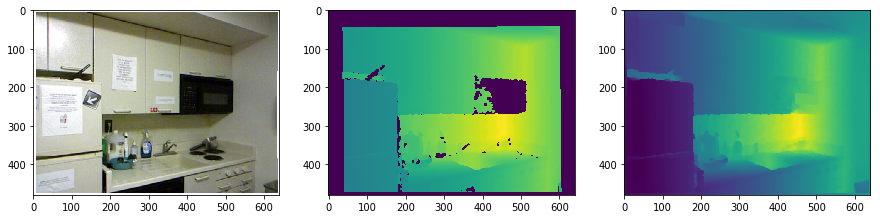

In [5]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(image1.squeeze(), -1))
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(raw_depth_1, -1))
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(label_depth_1, -1))

In [6]:
import requests

url = 'http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat'
r = requests.get(url, allow_redirects=True)
open('imagenet-vgg-verydeep-19.mat', 'wb').write(r.content)

534904783

In [7]:
vgg_model = load_vgg_model('imagenet-vgg-verydeep-19.mat')

W0718 21:56:41.903985 140316094900096 deprecation_wrapper.py:119] From /content/nst_utils.py:124: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



In [0]:
def vgg_features_for_a_sample(img):
    """
    Return: vgg features for a sample
    """
    vgg_model['input'].assign(img)
    return vgg_model['conv3_4']

In [0]:
def resize_img(img, H, W):
    """
    Resize an img to target size
    """
    return np.expand_dims(
        cv2.resize(img.squeeze(), (W, H), interpolation=cv2.INTER_LINEAR),
        axis=0
    )

In [10]:
resized_img_1 = resize_img(image1, 300, 400)
resized_img_1.shape

(1, 300, 400, 3)

In [11]:
vgg_features_for_a_sample(resized_img_1).shape

TensorShape([Dimension(1), Dimension(75), Dimension(100), Dimension(256)])

In [0]:
def search_k_nearest_labelled(y, x, matrix, k=10):
    """
    return k founded lablled neighbours, including (y, x) itself.

    k: number of labelled neighbors to search
    y: current point y
    x: current point x
    matrix: a binary H by W matrix, 1 is labelled and 0 is unlabelled

    return: coordinates of k nearest neighbours
    [(481, 180),
     (480, 179),
     (479, 178),
     (478, 177),
     (477, 176),
     (476, 175),
     (523, 222),
     (475, 174),
     (524, 223),
     (474, 173)]

    note: there is a bug if a node has less then k labelled neighbours but it is rarely happen in the case of depth map
    """
    H = matrix.shape[0]
    W = matrix.shape[1]
    founded_neighbours = []
    search_range_n_y = 0 # negative direction search range
    search_range_p_y = 0 # positive direction search range
    search_range_n_x = 0
    search_range_p_x = 0
    while len(founded_neighbours) < k:
#         print('- -')
        if y - search_range_n_y - 1 >= 0:
            search_range_n_y += 1
        if y + search_range_p_y + 1 < H:
            search_range_p_y += 1
        if x - search_range_n_x - 1 >= 0:
            search_range_n_x += 1
        if x + search_range_p_x + 1 < W:
            search_range_p_x += 1
        for y_index in range(y-search_range_n_y, y+search_range_p_y):
            for x_index in range(x-search_range_n_x, x+search_range_p_x):
#                 print(y_index, x_index)
                if matrix[y_index][x_index] == 1:
                    if (y_index, x_index) not in founded_neighbours:
                        founded_neighbours.append((y_index, x_index))
                if len(founded_neighbours) == k:
                    return founded_neighbours
        if y - search_range_n_y == 0 and y + search_range_p_y == H and x - search_range_n_x == 0 and x + search_range_p_x == W:
            return founded_neighbours

In [0]:
def show_founded_neighbours(x, y, raw_depth):
    '''
    Input: x, y coordinates in matplotlib plot system!
    '''
    mask_map = (raw_depth != 0).astype(int)    
    ns = search_k_nearest_labelled(y, x, mask_map)
#     print(ns)
    plt.imshow(mask_map)
    plt.scatter([(x[1]) for x in ns], [x[0] for x in ns], s=10, marker='.', c='r')
    return None

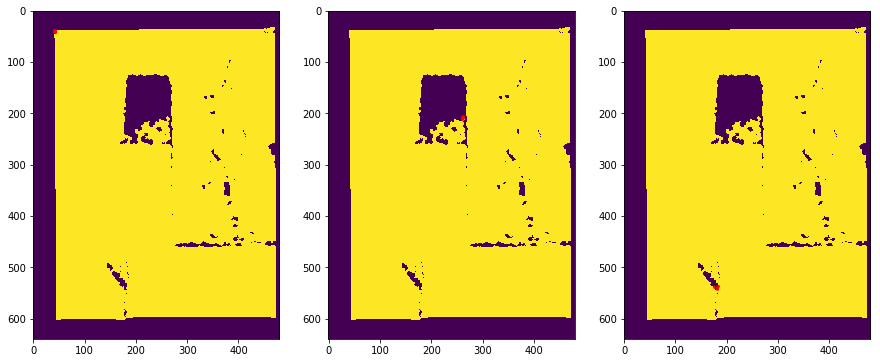

In [14]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
show_founded_neighbours(0, 0, raw_depth_1)
plt.subplot(1, 3, 2)
show_founded_neighbours(250, 200, raw_depth_1)
plt.subplot(1, 3, 3)
show_founded_neighbours(180, 540, raw_depth_1)

In [0]:
def adjacency_matrix_for_a_raw_depth_map(raw_depth, k):
    """
    Given a raw depth map, return its adjacency matrix when number of nn is specified as k
    
    k: number of nearest labelled neighbours for a missing depth pixel
    """
    mask_map = (raw_depth != 0).astype(int)
    H = mask_map.shape[0]
    W = mask_map.shape[1]
    N = H * W # number of nodes
    adj = np.zeros((N, N))
    for y in range(H): #for each row
        for x in range(W): #for each entry of the current row
            current_point_index_in_adj = y * W + x
#             if mask_map[y][x] == 0:
            if True:
                k_nearest_neighbours = search_k_nearest_labelled(y, x, mask_map, k=k)
                for labelled_neighbour in k_nearest_neighbours:
                    neighbour_index_in_adj = labelled_neighbour[0] * W + labelled_neighbour[1]
                    adj[current_point_index_in_adj][neighbour_index_in_adj] = adj[neighbour_index_in_adj][current_point_index_in_adj] = 1
    return adj

In [16]:
#test adj implementation correct

import numpy as np

test_depth = np.array([[0,0,0,0],
             [0,1,1,0],
             [0,2,1,0],
             [0,0,0,0]])

print(adjacency_matrix_for_a_raw_depth_map(test_depth, 3).shape)

adjacency_matrix_for_a_raw_depth_map(test_depth, 3)

(16, 16)


array([[0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,

In [0]:
def degree_matrix(A):
  result = np.zeros_like(A)
  N = len(A[0])
  for i in range(N):
    result[i][i] = np.sum(A[i])
  return result

In [0]:
def normalized_adj(raw_depth, k):
  adj = adjacency_matrix_for_a_raw_depth_map(raw_depth, k)
  d_matrix = degree_matrix(adj)
  return np.matmul(np.linalg.inv(d_matrix), adj)   

In [0]:
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [0]:
normalized_adj(test_depth, 3) == normalize(a)

In [0]:
resized_raw_depth_1 = resize_img(raw_depth_1, 75, 100)

In [42]:
adjacency_matrix_for_a_raw_depth_map(resized_raw_depth_1.squeeze(), 5).shape

(7500, 7500)

In [0]:
vgg_features_img_1 = vgg_features_for_a_sample(resized_img_1)

In [0]:
def vgg_features_to_gcn_for_an_img(vgg_features_of_an_img):
    """
    Convert vgg features (H * W * F) into (N * F) where N = H * W
    N: number of nodes
    """
    H = vgg_features_of_an_img.shape[1]
    W = vgg_features_of_an_img.shape[2]
    N = H * W
    result = np.zeros((N, vgg_features_of_an_img.shape[3]))
    for y in range(H): #for each row
            for x in range(W): #for each entry of the current row
                current_point_index = y * W + x
                result[current_point_index] = vgg_features_of_an_img[0][y][x]
    return result

In [45]:
(vgg_features_to_gcn_for_an_img(vgg_features_img_1)).shape

(7500, 256)

In [0]:
def neighbours_depth_for_a_pixel(y, x, raw_depth, k):
    mask_map = (raw_depth != 0).astype(int)
    neighbours = search_k_nearest_labelled(y, x, mask_map, k)
    result = []
    for neighbour in neighbours:
        result.append(raw_depth[neighbour[0]][neighbour[1]])
    return result

In [0]:
def depth_features_to_gcn_for_an_img(raw_depth, k):
    """
    Return: N * k
    """
    H = raw_depth.shape[0]
    W = raw_depth.shape[1]
    N = H * W
    result = np.zeros((N, k))
    for y in range(H): #for each row
            for x in range(W): #for each entry of the current row
                current_point_index = y * W + x
                result[current_point_index] = neighbours_depth_for_a_pixel(y, x, raw_depth, k)
    return result

In [48]:
(depth_features_to_gcn_for_an_img(resized_raw_depth_1.squeeze(), 5)).shape

(7500, 5)

In [0]:
def fuse_vgg_and_depth_features(vgg_features, depth_features):
    """
    Return: N * (256 + k)
    """
    return np.concatenate((vgg_features, depth_features), axis=1)

In [0]:
vgg_features = vgg_features_to_gcn_for_an_img(vgg_features_img_1)
depth_features = depth_features_to_gcn_for_an_img(resized_raw_depth_1.squeeze(), 5)

In [0]:
fused_feature = fuse_vgg_and_depth_features(vgg_features, depth_features)

In [52]:
vgg_features.shape, depth_features.shape, fused_feature.shape

((7500, 256), (7500, 5), (7500, 261))

In [0]:
resized_labelled_depth_1 = resize_img(label_depth_1, 75, 100)

In [0]:
def gcn_labels_from_labelled_depth(labelled_depth):
    """
    Return: N * 1
    """
    H = labelled_depth.shape[0]
    W = labelled_depth.shape[1]
    N = H * W
    result = np.zeros((N, 1))
    for y in range(H): #for each row
            for x in range(W): #for each entry of the current row
                current_point_index = y * W + x
                result[current_point_index] = labelled_depth[y][x]
    return result

In [0]:
Y = gcn_labels_from_labelled_depth(resized_labelled_depth_1.squeeze())

# Y = gcn_labels_from_labelled_depth(label_for_just_missing_depth)

A = adjacency_matrix_for_a_raw_depth_map(resized_raw_depth_1.squeeze(), 20)
A = normalize(A)

X = fuse_vgg_and_depth_features(vgg_features, depth_features)
# X = depth_features

Y = tf.convert_to_tensor(Y, dtype=tf.float32)
A = tf.convert_to_tensor(A, dtype=tf.float32)
X = tf.convert_to_tensor(X, dtype=tf.float32)

In [122]:
Y.shape, X.shape, A.shape

(TensorShape([Dimension(7500), Dimension(1)]),
 TensorShape([Dimension(7500), Dimension(261)]),
 TensorShape([Dimension(7500), Dimension(7500)]))

In [0]:
def loss(y_hat, y):
    return tf.reduce_mean(tf.square(y_hat - y))

In [0]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape: 
        loss_value = loss(model(inputs), targets)
    return loss_value, tape.gradient(loss_value, [model.w1])

In [0]:
class Model(object):
    def __init__(self, adj):
        self.adj = adj
        self.w1 = tf.Variable(tf.random_uniform([261, 512], -1.0, 1.0) * 0.01)
        self.w2 = tf.Variable(tf.random_uniform([512, 128], -1.0, 1.0) * 0.01)
        self.w3 = tf.Variable(tf.random_uniform([128, 1], -1.0, 1.0) * 0.01)
#         self.b = tf.Variable(tf.zeros([128]))
    def __call__(self, x):
        result = tf.matmul(tf.matmul(self.adj, x), self.w1)
#         result = tf.matmul(x, self.w1)

        result = tf.nn.relu(result)
        result = tf.matmul(result, self.w2)
    
        result = tf.nn.relu(result)
        result = tf.matmul(self.adj, (tf.matmul(result, self.w3)))
        
        return result

In [124]:
model = Model(A)
model(X).shape

TensorShape([Dimension(7500), Dimension(1)])

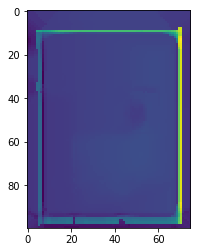

In [125]:
test_result = tf.matmul(A, X)
show_model_outputs(np.mean(test_result, axis=1))

In [126]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
global_step = tf.Variable(0)
model = Model(A)

from tensorflow import contrib
tfe = contrib.eager

num_epoches = 1000

for epoch in range(num_epoches):
  
    epoch_loss_avg = tfe.metrics.Mean()

    loss_value, grads = grad(model, X, Y)
    optimizer.apply_gradients(zip(grads, [model.w1]), global_step)

    epoch_loss_avg(loss_value)  # add current batch loss

#     train_loss_results.append(epoch_loss_avg.result())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss: {epoch_loss_avg.result()}")

Epoch 170: Loss: 0.09303327649831772
Epoch 180: Loss: 0.09251272678375244
Epoch 190: Loss: 0.09199562668800354
Epoch 200: Loss: 0.09147881716489792
Epoch 210: Loss: 0.09095828980207443


KeyboardInterrupt: ignored

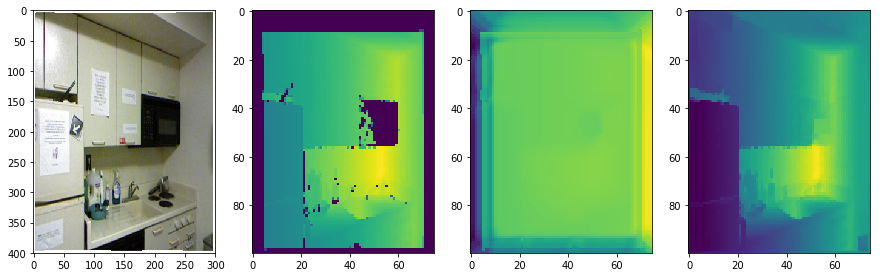

In [127]:
resized_raw_depth_1 = resize_img(raw_depth_1, 75, 100)

plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(np.rot90(resized_img_1.squeeze(), -1))
plt.subplot(1,4,2)
# show_model_outputs(Y)
plt.imshow(np.rot90(resized_raw_depth_1.squeeze(), -1))
plt.subplot(1,4,3)
show_model_outputs(model(X))
plt.subplot(1,4,4)
plt.imshow(np.rot90(resized_labelled_depth_1.squeeze(), -1))

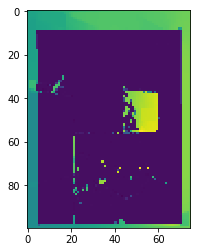

In [88]:
plt.imshow(np.rot90((resized_labelled_depth_1.squeeze() - resized_raw_depth_1.squeeze()), -1))

In [0]:
label_for_just_missing_depth = resized_labelled_depth_1.squeeze() - resized_raw_depth_1.squeeze()

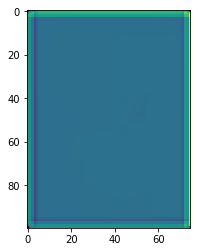

In [72]:
show_model_outputs(np.mean(X, axis=1))

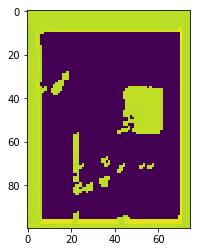

In [73]:
test_result = tf.matmul(A, X)
show_model_outputs(np.mean(test_result, axis=1))

In [0]:
def reconstruct_depth(y_pred):
    '''
    y_pred: N by 1
    
    return: H * W
    '''
    
    H = 75
    W = 100
    recon_depth = np.zeros((H, W))
    
    for y in range(H): #for each row
            for x in range(W): #for each entry of the current row
                current_point_index = y * W + x
                recon_depth[y][x] = y_pred[current_point_index]
    return recon_depth
  
def show_model_outputs(y_hat):
    plt.imshow(np.rot90(reconstruct_depth(y_hat), -1))